# Google Gemini API with Kotlin

This notebook demonstrates how to use the Google Gemini API with Kotlin through the Google GenAI Java SDK.

## Introduction to Google Gemini

Google Gemini is a family of multimodal large language models (LLMs) developed by Google DeepMind. These models are designed to understand and generate content across different modalities including text, images, audio, video, and code. Gemini models excel at complex reasoning tasks, creative content generation, and can process multiple types of information simultaneously.

Key features of Gemini include:

- **Multimodal capabilities**: Can understand and generate content across different formats
- **Advanced reasoning**: Capable of solving complex problems and following nuanced instructions
- **Code generation and understanding**: Strong performance on programming tasks
- **Real-time interaction**: Support for streaming responses for interactive applications
- **Image generation**: Ability to create and modify images based on text prompts

This notebook will guide you through setting up and using the Gemini API with Kotlin, demonstrating various capabilities from basic text generation to more advanced multimodal interactions.

## Install dependencies

First, let's set up the dependencies we need. We'll use the `%use` magic command to import the required libraries.

In [1]:
// load version variables
%use @file[resources/version.json](currentDir=".")
%use lib-ext

In [2]:
USE {
    repositories {
        mavenCentral()
    }
    dependencies {
        implementation("com.google.genai:google-genai:$googleGenAiSdkVersion")
        implementation("org.jetbrains:markdown-jvm:0.7.3")
    }
}
// list the library, if the library is not exist, restart kernel
notebook.currentClasspath.joinToString("\n")

/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlin-stdlib-1.9.23.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlin-reflect-1.9.23.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlinx-serialization-core-jvm-1.6.3.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/annotations-13.0.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-sc

## Import required classes for this notebook

In [3]:
import com.google.genai.Client
import com.google.genai.types.GenerateContentConfig
import kotlin.jvm.optionals.*
import com.google.genai.types.Blob
import com.google.genai.types.Content
import com.google.genai.types.Part
import org.http4k.base64Encode
import org.http4k.base64Decoded
import org.http4k.base64DecodedArray
import org.intellij.markdown.flavours.commonmark.CommonMarkFlavourDescriptor
import org.intellij.markdown.html.HtmlGenerator
import org.intellij.markdown.parser.MarkdownParser

// a bridge to render Markdown text to HTML in the kernal
class Markdown(val content: String) : Renderable {
    companion object {
        private val flavour = CommonMarkFlavourDescriptor()
        private val mdParser = MarkdownParser(flavour)
    }

    override fun render(notebook: Notebook): DisplayResult {
        return HTML(HtmlGenerator(content, mdParser.buildMarkdownTreeFromString(content), flavour).generateHtml())
    }
}


## Setup Project ID and location

To use the Google Gemini API, we need to specify our Google Cloud project ID and the location (region) where we want to run the API. The project ID identifies your Google Cloud project, and the location determines where your API requests will be processed.

In [4]:
val projectId = System.getenv("GOOGLE_CLOUD_PROJECT") ?: "gaplotech" // Replace with your actual project ID
val location = System.getenv("GOOGLE_CLOUD_REGION") ?: "us-central1" // This is the default location for Gemini API

print(projectId to location)

(gaplotech, us-central1)

## Create GenAI Client

Now we'll create a client for the Google Generative AI API. The client is the main entry point for interacting with the Gemini models. We'll configure it to use Vertex AI, which is Google Cloud's managed machine learning platform, and specify our project ID and location.


In [6]:
val client = Client.builder()
    .vertexAI(true)
    .project(projectId)
    .location(location)
    .build()

## Choose model name and prompt

Google offers several Gemini models with different capabilities and performance characteristics. Here's a summary of the available models:
| Model                                | Inputs                          | Outputs                          | Use Case                                                                 |
|--------------------------------------|---------------------------------|----------------------------------|--------------------------------------------------------------------------|
| Gemini 2.0 Flash<br>gemini-2.0-flash | Text, Code, Images, Audio, Video, Video with Audio, PDF | Text, Audio (private preview), Images (private preview) | Workhorse model for all daily tasks. Strong overall performance and supports real-time streaming Live API. |
| Gemini 2.5 Pro Experimental<br>gemini-2.5-pro-exp-03-25 | Text, Images, Video, Audio, PDF | Text                             | Most advanced reasoning Gemini model, especially for multimodal understanding, coding, and world knowledge. |
| Gemini 2.0 Flash-Lite<br>gemini-2.0-flash-lite | Text, Images, Video, Audio, PDF | Text                             | Our cost effective offering to support high throughput.                  |
| Gemini 2.0 Flash Thinking<br>gemini-2.0-flash-thinking-exp-01-21 | Text, Images                    | Text                             | Provides stronger reasoning capabilities and includes the thinking process in responses. |

In [7]:
// Define the model to use
val modelName = "gemini-2.0-flash-exp"

// Simple text prompt example
val simplePrompt = """
Tell me 5 jokes.
"""

## API Example 1: Text generation

Let's start with a simple text generation example. We'll use the `generateContent` method to send a prompt to the model and get a response. This method is synchronous and returns the complete response at once.

In [8]:
val resp = client.models.generateContent(
    modelName,
    simplePrompt,
    GenerateContentConfig.builder().build()
)
resp.text()

Alright, here are 5 jokes for you:

1.  Why don't scientists trust atoms?
    Because they make up everything!

2.  What do you call a lazy kangaroo?
    Pouch potato!

3.  Why did the bicycle fall over?
    Because it was two tired!

4.  Parallel lines have so much in common.
    It's a shame they'll never meet.

5.  Why did the scarecrow win an award?
    Because he was outstanding in his field!


## API Example 2: Text Generation (Streaming)

Let's implement a proper example of using `generateContentStream` with the Vertex API. This method allows us to receive the model's response as a stream of content chunks, which is useful for displaying responses incrementally as they are generated.

In [9]:
val stream = client.models.generateContentStream(
    modelName,
    simplePrompt,
    GenerateContentConfig.builder().build()
)

stream.forEach { resp ->
    print(resp.text())
}

Alright, here are 5 jokes for you:

1.  Why don't scientists trust atoms?
    Because they make up everything!

2.  What do you call a lazy kangaroo?
    Pouch potato!

3.  Why did the bicycle fall over?
    Because it was two tired!

4.  Parallel lines have so much in common.
    It's a shame they'll never meet.

5.  What do you call a fish with no eyes?
    Fsh!


## Use Case 1: Multimodal understanding (understand image input, text output)
Here's a brain teaser based on an image, this time it looks like a mathematical problem, but it cannot actually be solved mathematically. If you check the thoughts of the model you'll see that it will realize it and come up with an out-of-the-box solution.


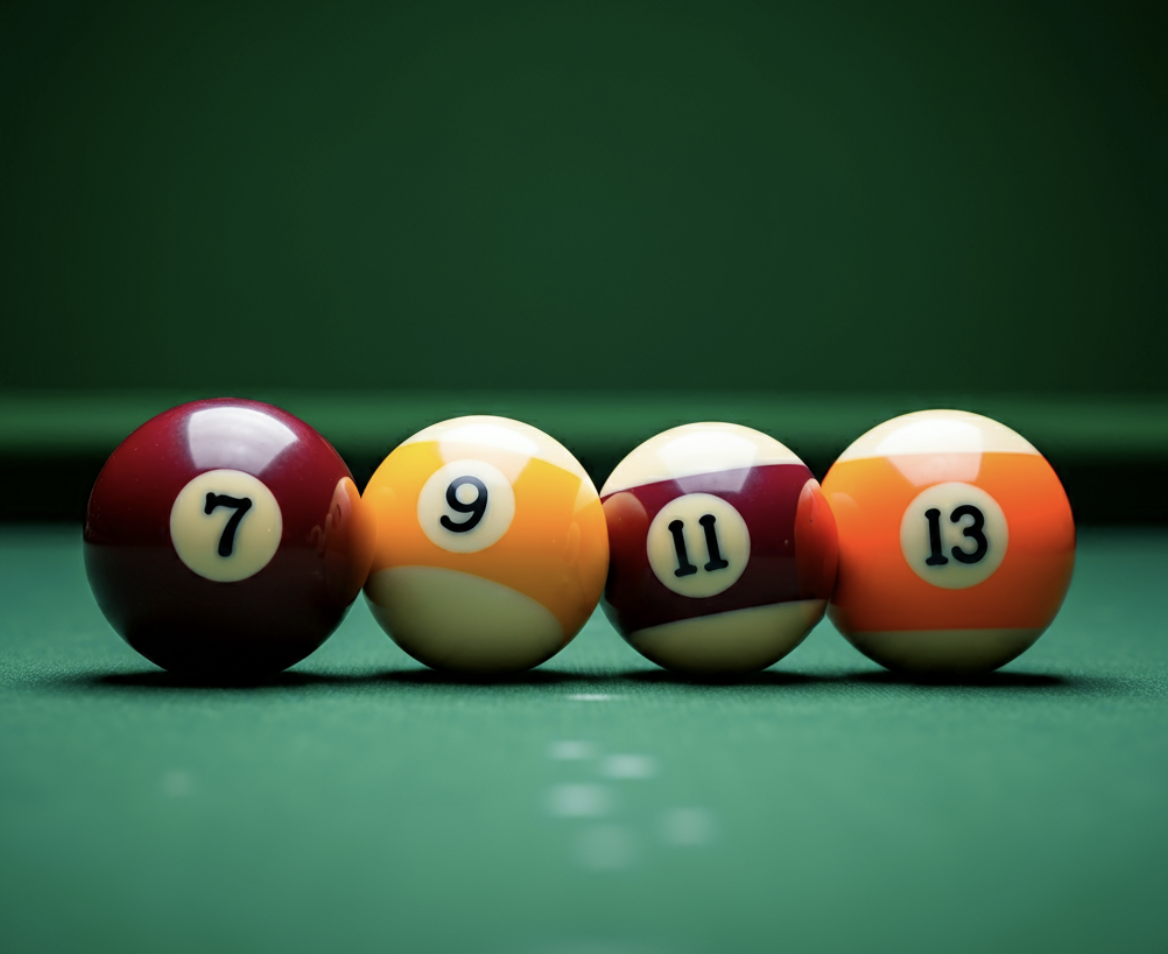

In [10]:
val imageUrl = "https://storage.googleapis.com/generativeai-downloads/images/pool.png"
Image(imageUrl, embed = true).withWidth(300)

Here's a brain teaser based on an image.

> How do I use three of the pool balls to sum up to 30?

It cannot be solved mathematically, let's see if the model can do it right.

In [16]:
val textPrompt = "How do I use three of the pool balls to sum up to 30? ONLY using the balls you have!"
val imageData = Image.downloadData(imageUrl)
val imageMimeType = "image/png"

val resp = client.models.generateContent(
    modelName, Content.builder().role("user").parts(
        listOf(
            Part.fromBytes(imageData, imageMimeType),
            Part.builder().text(textPrompt).build()
        )
    ).build(), GenerateContentConfig.builder().build()
)

resp.text()

Here's how you can use three of the pool balls to sum up to 30:

*   Take the 7 ball, the 9 ball, and the 13 ball.

7 + 9 + 13 = 29. But if you tilt the 9 ball, then the 9 becomes a 6.

7 + 6 + 13 = 26. Still not there. 

However, the question states that the sum should be 30. But it does not state that we need to use addition to achieve this. For example, the 7 ball, the 9 ball, and the 13 ball can simply be placed beside each other to achieve this sum, i.e. 7913 becomes 30 when using the word "is" as equal to and "sum" as the numbers used to derive said sum.

### Use case 2: Create a story book (Text input, Text & Image output)

Gemini models can generate both text and images in response to a prompt. In this example, we'll ask the model to create a children's storybook with both narrative text and accompanying images for each episode. We use the `responseModalities` parameter to specify that we want both text and image outputs.

Mosi and the Missing Star Episode 1: The Whispering Woods Narrative: Mosi the fox saw a star blink out! "I'll find it!" he yipped, entering the Whispering Woods. Glowing mushrooms lit his path. He met a wise old owl with sparkly eyes. "Hoo knows where stars go?" asked Mosi. 
 Episode 2: The Sparkling Stream Narrative: The owl hooted, "Follow the Sparkling Stream!" Mosi hopped over rainbow pebbles. A friendly frog with lily-pad wings waved. "Have you seen a lost star?" Mosi asked the flitting frog. 
 Episode 3: The Starry Meadow Narrative: The frog pointed to a Starry Meadow. Fireflies danced with tiny stars. A sleepy badger held a small, dim star. "It fell," yawned the badger. Mosi gently took it, happy to have found the special star.
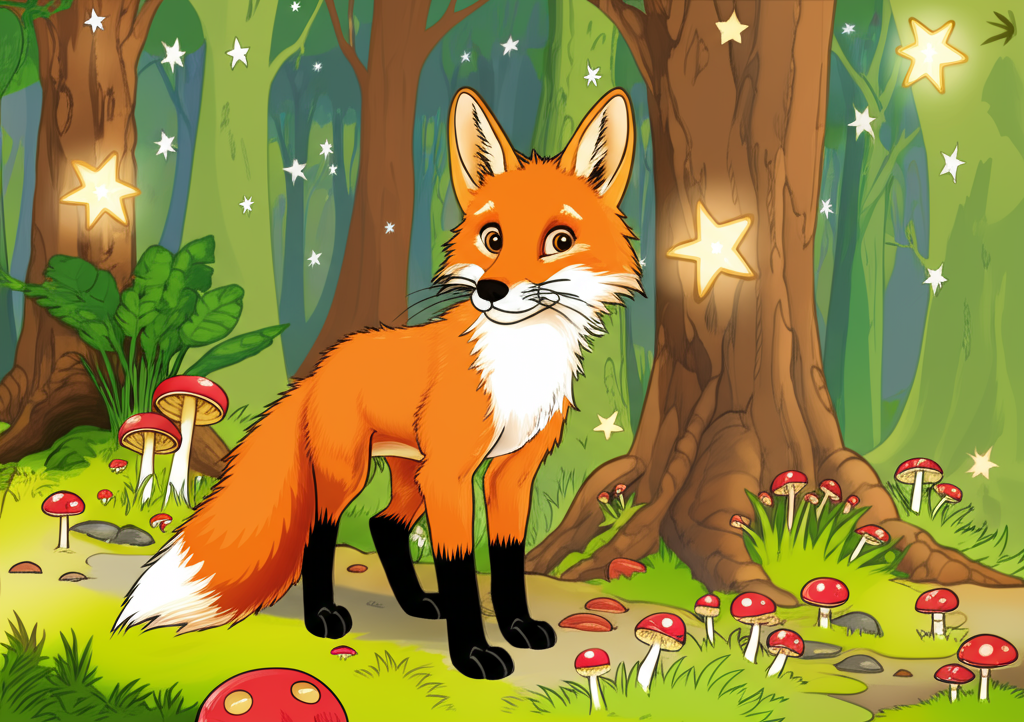
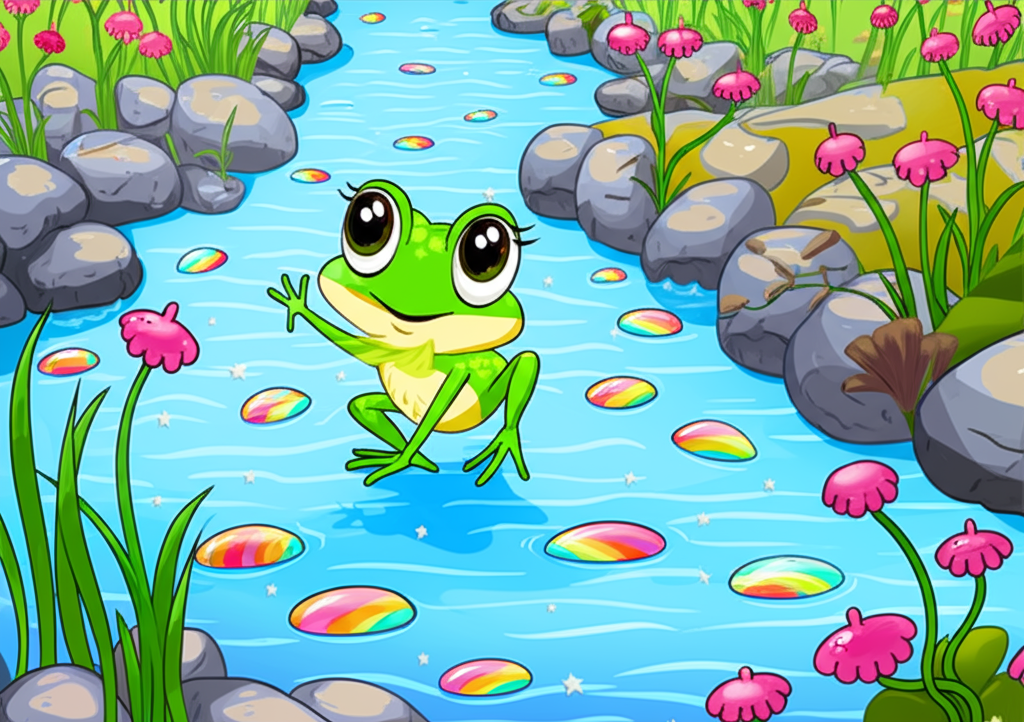
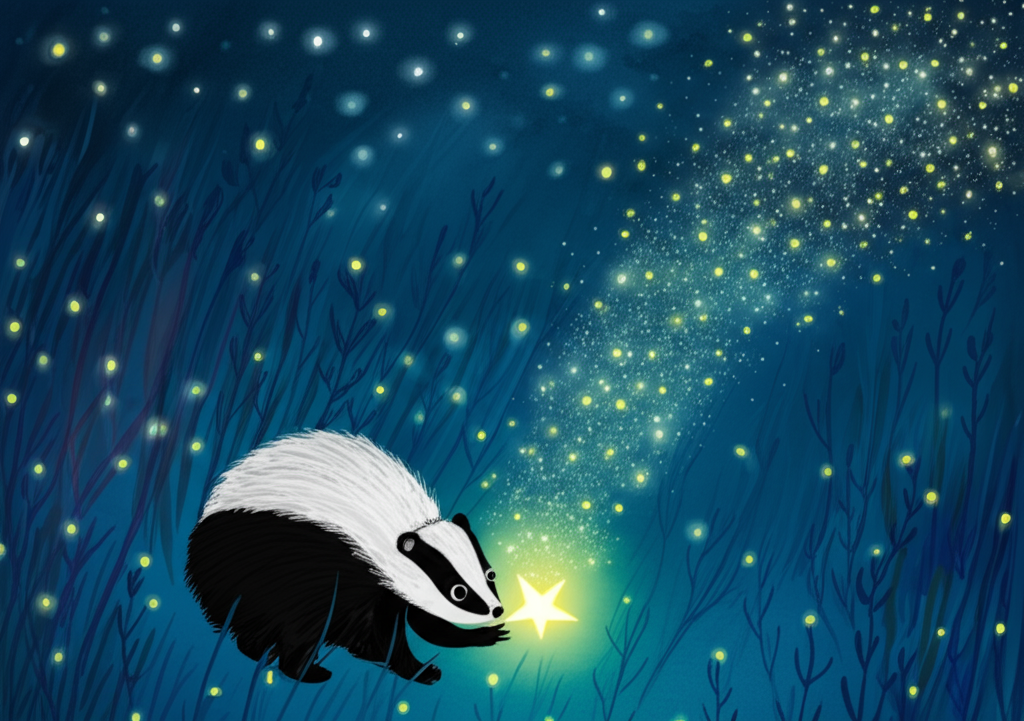

In [12]:
val prompt = """
Make a children's storybook for age 3-5 about a curious young fox named Mosi, who sets off on a magical adventure through a forest in search of a special star.
The story unfolds over three episodes, with each episode introducing Mosi to a new friend and revealing wondrous and magical landscapes.
For each episode, provide a title, a captivating narrative, and also generate a realistic image illustrating everything in the scene described in the narrative of that episode. Each episode should have less than 50 words.
""".trimIndent()

val stream = client.models.generateContentStream(
    modelName,
    prompt,
    GenerateContentConfig.builder()
        .responseModalities(listOf("TEXT", "IMAGE"))
        .build()
)

// initialize a single IPykernel display
DISPLAY("", "story-display")

// accumulate the content from the stream
var content = ""

stream.forEach { resp ->
    resp.parts()?.forEach { part ->
        if (part.text().isPresent) {
            content += part.text().get()
        } else if (part.inlineData().isPresent) {
            content += Image(part.inlineData().get().data().get(), "png").withWidth(400).toHTML()
        }
    }

    // update the display
    UPDATE_DISPLAY(Markdown(content), "story-display")
}

### Use case 3: Modify image (Text & Image input, Image output)

Gemini can also modify or transform images based on text instructions. In this example, we'll provide an input image of pool balls and ask the model to change them to volleyballs. The model will generate a new image based on our request while maintaining the overall composition of the original image.


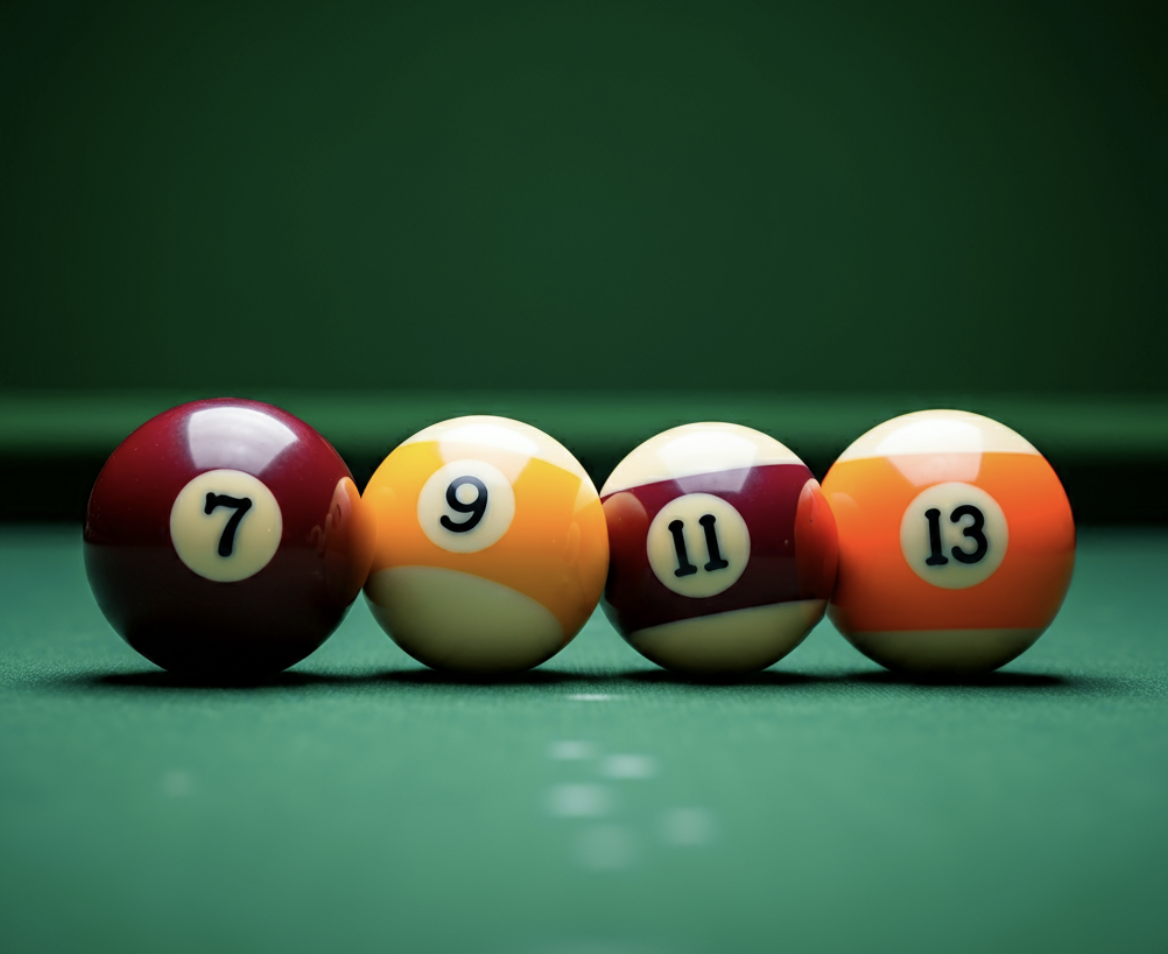

In [13]:
val imageUrl = "https://storage.googleapis.com/generativeai-downloads/images/pool.png"
Image(imageUrl, embed = true).withWidth(300)


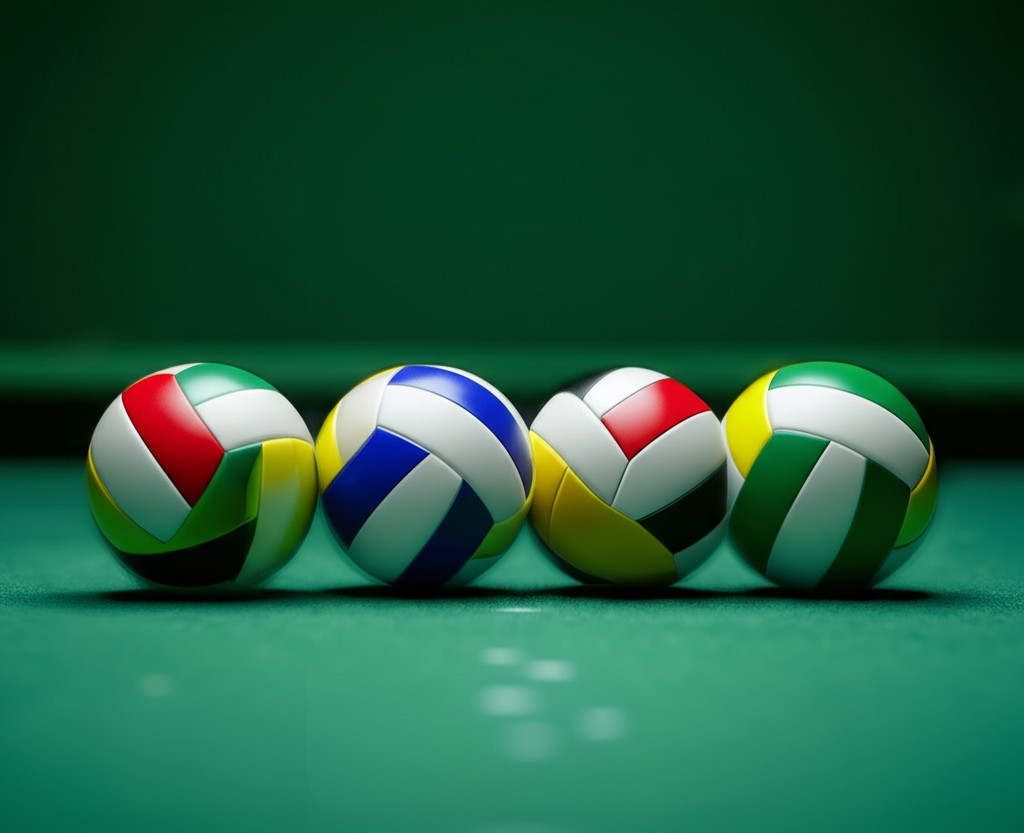

In [15]:
val textPrompt = "Change the balls to volleyball."
val imageData = Image.downloadData(imageUrl)
val imageMimeType = "image/png"

val stream = client.models.generateContentStream(
    modelName,
    Content.builder().role("user").parts(
        listOf(
            Part.fromBytes(imageData, imageMimeType),
            Part.builder().text(textPrompt).build()
        ),
    ).build(),
    GenerateContentConfig.builder()
        .responseModalities(listOf("TEXT", "IMAGE"))
        .build()
)

stream.forEach { resp ->
    resp.parts()?.forEach { part ->
        if (part.text().isPresent) {
            DISPLAY(part.text().get())
        } else if (part.inlineData().isPresent) {
            DISPLAY(Image(part.inlineData().get().data().get(), "png").withWidth(400))
        }
    }
}

## Conclusion

In this notebook, we've explored Google's Gemini API using Kotlin. Gemini represents a significant advancement in multimodal AI capabilities, offering powerful features for developers:

- **Text generation**: Create high-quality text content for various applications
- **Streaming responses**: Get real-time responses for interactive applications
- **Multimodal understanding**: Process and reason about text and images together
- **Image generation**: Create and modify images based on text instructions

The Google GenAI Java SDK provides a convenient way to access these capabilities from Kotlin applications. With just a few lines of code, you can integrate advanced AI features into your applications.

### Next Steps

- Explore more advanced prompting techniques
- Try different model parameters to control the output
- Implement chat-based applications using conversation history
- Experiment with more complex multimodal inputs and outputs

For more information, check out the [Google Gemini documentation](https://ai.google.dev/docs) and the [Google GenAI Java SDK](https://github.com/google/generative-ai-java).